# Cambodia Cube - Water Analysis Notebook 

**Description:** This Python notebook allows users to directly interact with a Cambodia Cube to perform water classification. The following steps will allow users to connect to a data cube, define the analysis location and time period (extent of latitude/longitude and dates), and then run the Australian Water Observations from Space (WOFS) algorithm. 

The outputs of the WOFS algorithm include static and time series pixel-level water observations for any pixel. These results provide critical information for water management that will allow users to assess water cycle dynamics, historical water extent and the risk of floods and droughts.
****
Ensure:
- Cambodia Cube ('cambodia.conf') is saved and configured. 
- 'module load dea-env'
*****
This notebook is based on a CEOS notebook https://github.com/ceos-seo/data_cube_notebooks/blob/master/water_detection.ipynb 

The water classifier is based on Mueller, et al. (2015) "Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia." Remote Sensing of Environment. https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py



## Import libraries

In [1]:
# %matplotlib inline
%pylab notebook

from matplotlib import pyplot as plt
import ipywidgets as widgets

from datetime import datetime
import numpy as np
import gc
import warnings

import datacube
from datacube.storage import masking
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


## Link to Cambodia Cube

In [2]:
from datacube import Datacube
dc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf')

## Define functions

In [3]:
# def nan_to_num(dataset, number):
#     for key in list(dataset.data_vars):
#         dataset[key].values[np.isnan(dataset[key].values)] = number
        
def water_classifier(dataset_in):
    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)

    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Water claddifier. Regression analysis based on Australia training data.
        """

        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)

        #classified = np.ones(shape, dtype='uint8')

        classified = np.full(shape, no_data, dtype='uint8')

        # Start with the tree's left branch, finishing nodes as needed

        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0  #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1  #Node 6
        classified[_tmp2 & ~r4] = 0  #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1  #Node 10
        classified[_tmp2 & ~r6] = 0  #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1  #Node 14
        classified[_tmp2 & ~r8] = 0  #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1  #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1  #Node 19
        classified[_tmp & ~r10] = 0  #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()

        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0  #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0  #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1  #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1  #Node 31
        classified[_tmp2 & ~r16] = 0  #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1  #Node 33
        classified[_tmp2] = 0  #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0  #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0  #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0  #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0  #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1  #Node 44
        classified[_tmp & ~r22] = 0  #Node 45

        # Completed regression tree

        return classified
    
    blue = dataset_in.blue
    green = dataset_in.green
    red = dataset_in.red
    nir = dataset_in.nir
    swir1 = dataset_in.swir1
    swir2 = dataset_in.swir2

    dtype = blue.values.dtype 
    shape = blue.values.shape

    no_data =-9999

    classified = _run_regression(blue.values, green.values, red.values, nir.values, swir1.values, swir2.values)

    classified_clean=classified.astype('float64')
    
    y = dataset_in.y
    x = dataset_in.x

    time = None
    coords = None
    dims = None

    time = dataset_in.time
    coords = [time, y, x]
    dims = ['time', 'y', 'x']

    data_array = xr.DataArray(classified_clean, coords=coords, dims=dims)

    dataset_out = xr.Dataset(
            {
                'wofs': data_array
            }, coords={'time': time,
                       'y': y,
                       'x': x})
    return dataset_out

def LoadAreaofInterest(sensors, bands_of_interest, query, cloud_free_threshold):
    """
    Description:
    Load data from datacube for multiple sensors
    -----
    Output:
      dataset_out (xarray.DataSet) - dataset containing landsat band information for specified sensors
    """

    for sensor in sensors: #loop through specified
        sensor_nbar = dc.load(product= sensor+'_usgs_sr_scene',
                               measurements = bands_of_interest,group_by='solar_day', 
                               **query) #load nbar
        #retrieve the projection information before masking/sorting
        crs = sensor_nbar.crs
        crswkt = sensor_nbar.crs.wkt
        affine = sensor_nbar.affine
        #assign pq data variable
        sensor_pq= sensor_nbar.pixel_qa
        #create and use quality and cloud masks
        mask_components = {'cloud_shadow': 'no_cloud_shadow',
                   'cloud': 'no_cloud',}
        quality_mask = masking.make_mask(sensor_pq, **mask_components)
        good_data = quality_mask.loc[start_of_epoch:end_of_epoch]
        sensor_nbar2 = sensor_nbar.where(good_data)
        del (sensor_nbar)

        #calculate the percentage cloud free for each scene
        cloud_free = masking.make_mask(sensor_pq,
                                       cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')
        mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        del(cloud_free)
        #discard data that does not meet the cloud_free_threshold
        mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', 
                                                                   how='all')
        del(sensor_nbar2)
        #assign masked data to array
        sensor_clean[sensor] = mostly_good

        print('loaded %s' % sensor) 
    print('ls load complete')
    
    nbar_clean = xr.concat(sensor_clean.values(), 'time')
    nbar_clean = nbar_clean.sortby('time')
    nbar_clean.attrs['crs'] = crs
    nbar_clean.attrs['affin|e'] = affine
    return nbar_clean


#Define function to define the coordinates for the study area
def AreaOfInterest(study_area):
    if study_area == 'phumsrahkaev':
        lat_min = 13.000 #down
        lat_max = 13.100 #up
        lon_min = 103.300 #left
        lon_max = 103.400 #right  
    elif study_area == 'outapaong':
        lat_min = 12.600 #down
        lat_max = 12.800 #up
        lon_min = 103.600 #left
        lon_max = 103.800 #right
    elif study_area == 'mondulkiri':
        lat_min = 12.863 #down
        lat_max = 13.663 #up
        lon_min = 106.350 #left
        lon_max = 107.236 #right
    elif study_area == 'krongstungtreng':
        lat_min = 13.181 #down
        lat_max = 13.681 #up
        lon_min = 105.781 #left
        lon_max = 106.381 #right
    elif study_area == 'kaohnheaek':
        lat_min = 13.000 #down
        lat_max = 13.100 #up
        lon_min = 107.000 #left
        lon_max = 107.100 #right
    elif study_area == 'neakleoang':
        lat_min = 11.246 #down
        lat_max = 11.532 #up
        lon_min = 105.141 #left
        lon_max = 105.380 #right
    elif study_area == 'tonlesaplake':
        lat_min = 13.020 #down
        lat_max = 13.120 #up
        lon_min = 103.740 #left
        lon_max = 103.840 #right
    else:
        print('FileNotFoundError')
    return lat_min, lat_max, lon_min, lon_max

# Query and extract data from Cambodia Cube

In [4]:
#User input: define name of study area
study_area = 'phumsrahkaev' #name of study area
study_area=study_area.lower().replace(" ","") #reformat to remove uppercase and spaces

In [5]:
#Coordinates for the area of interest are loaded. Coordinates are defined in the function section above
lat_min, lat_max, lon_min, lon_max = AreaOfInterest(study_area)

In [6]:
#User input: define details below

#define temporal range
start_of_epoch = '2010-01-01'
end_of_epoch =  '2018-01-01'

#define wavelengths/bands of interest
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'pixel_qa',
                     'swir2',
                     ]

#set cloud free threshold
cloud_free_threshold = 0.10

#define Landsat sensors of interest
sensors = ['ls8','ls7','ls5'] 

In [7]:
#Query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print (query)

{'time': ('2010-01-01', '2018-01-01'), 'x': (103.3, 103.4), 'y': (13.1, 13.0), 'crs': 'EPSG:4326'}


In [8]:
#Load data from Cambodia Cube
sensor_clean = {}
nbar_clean = LoadAreaofInterest(sensors, bands_of_interest, 
                                query, cloud_free_threshold) #use function created above
print (nbar_clean)

loaded ls8
loaded ls7
loaded ls5
ls load complete
<xarray.Dataset>
Dimensions:   (time: 205, x: 365, y: 372)
Coordinates:
  * y         (y) float64 1.449e+06 1.449e+06 1.449e+06 1.449e+06 1.449e+06 ...
  * x         (x) float64 3.156e+05 3.156e+05 3.157e+05 3.157e+05 3.157e+05 ...
  * time      (time) datetime64[ns] 2010-01-24T03:16:38.327013 ...
Data variables:
    blue      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    green     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    red       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    nir       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir1     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    pixel_qa  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir2     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      PROJCS["WGS 84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROI

In [9]:
# #Unhash and set dates if a subset of dates is required
# nbar_clean_subset = nbar_clean.sel(time=slice('2014-01-01','2015-01-01'))

# Classify water and calculate Water Observations from Space (WOfS)

## Use water classifier function

In [10]:
#Use water clasifier function created above
warnings.filterwarnings('ignore') #turn off warnings
water_class = water_classifier(nbar_clean)#_subset) #use function
warnings.filterwarnings('always') #turn on warnings
print(water_class)

<xarray.Dataset>
Dimensions:  (time: 205, x: 365, y: 372)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-24T03:16:38.327013 ...
  * y        (y) float64 1.449e+06 1.449e+06 1.449e+06 1.449e+06 1.449e+06 ...
  * x        (x) float64 3.156e+05 3.156e+05 3.157e+05 3.157e+05 3.157e+05 ...
Data variables:
    wofs     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


## Calculate and plot WOfS

In [11]:
total_water_obs = water_class.wofs.sum(dim='time')
nbar_count = nbar_clean.pixel_qa.count(dim='time')
wofs = ((total_water_obs/nbar_count)*100)

In [12]:
#Set up colour ramp details to meet DEA specified colour details
# wofs_cmap = mpl.colors.ListedColormap(['#000000', '#8e0101', '#cf2200', '#e38400',
#                                        '#e3df00', '#a6e300', '#62e300', '#00e32d',
#                                        '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
#                                        '#005fe3', '#000fe3', '#5700e3'])
wofs_cmap = mpl.colors.ListedColormap(['#000000', '#e38400', '#e3df00', '#62e300',
                                       '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
                                       '#005fe3', '#000fe3', '#5700e3'])
wofs_bounds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)

<IPython.core.display.Javascript object>


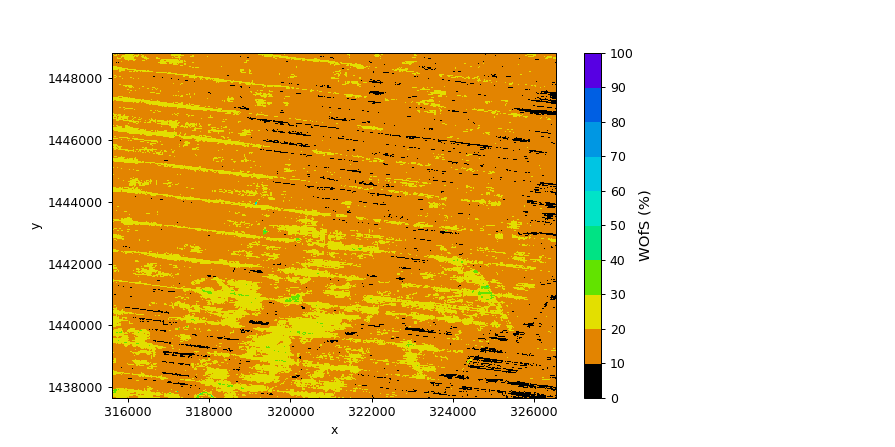

In [13]:
#Create WOfS image with specified colour ramp details
fig = plt.figure(figsize =(10,5)) 
i=wofs.plot.imshow(cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)
plt.colorbar(i, ticks=wofs_bounds, 
            ).set_label(label='WOfS (%)',
             size=12) #Add definable colour bar
fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar

plt.show() #Create image